<a href="https://colab.research.google.com/github/duwei0227/pytorch-book-learning/blob/master/chapter4-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B7%A5%E5%85%B7%E7%AE%B1nn/%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B7%A5%E5%85%B7%E7%AE%B1nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Notebook')

In [0]:
import torch
from torch import nn

In [0]:
class Linear(nn.Module):
  def __init__(self, in_features, out_features):
    super(Linear, self).__init__()
    self.w = nn.Parameter(torch.randn(in_features, out_features))
    self.b = nn.Parameter(torch.randn(out_features))
    
  def forward(self, x):
    x = x.mm(self.w) # 矩阵相乘
    return x + self.b.expand_as(x)

In [0]:
layer = Linear(4, 3)
input = torch.randn(2, 4)
output = layer(input)
output

tensor([[ 0.4319,  2.9580, -1.4187],
        [ 1.3572,  2.1828, -2.5659]], grad_fn=<AddBackward0>)

In [0]:
for name, parameter in layer.named_parameters():
  print(name, parameter)

w Parameter containing:
tensor([[ 0.8692,  0.9701, -1.2517],
        [-0.6148,  0.9721,  1.1827],
        [-1.3046,  0.2824,  0.1790],
        [-0.9784, -0.8796,  0.0396]], requires_grad=True)
b Parameter containing:
tensor([ 0.4731,  1.9315, -0.4412], requires_grad=True)


In [0]:
class Perception(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super(Perception, self).__init__()
    
    self.layer1 = Linear(in_features, hidden_features)
    self.layer2 = Linear(hidden_features, out_features)
    
  def forward(self, x):
    x = self.layer1(x)
    x = torch.sigmoid(x)
    return self.layer2(x)

In [0]:
perception = Perception(3, 4, 1)
for name, param in perception.named_parameters():
  print(name, param)

layer1.w Parameter containing:
tensor([[-0.4712, -1.7427, -0.8316, -0.2081],
        [-0.4200, -0.1247, -0.7281,  1.4491],
        [ 1.3213,  1.7658, -0.4028,  0.8004]], requires_grad=True)
layer1.b Parameter containing:
tensor([-0.1495, -1.5098,  0.0135, -0.3316], requires_grad=True)
layer2.w Parameter containing:
tensor([[-1.0642],
        [-0.9523],
        [-1.7319],
        [ 1.1138]], requires_grad=True)
layer2.b Parameter containing:
tensor([0.2803], requires_grad=True)


### 常用神经网络

#### 图像相关层
主要包括卷积层(Conv)、池化层(Pool)等，这些层在实际使用中可以分为一维(1D)、二维(2D)、三维(3D)，池化层又可分为平均池化(AvgPool)、最大池化(MaxPool)、自适应池化(AdaptiveAvgPool)等

In [0]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

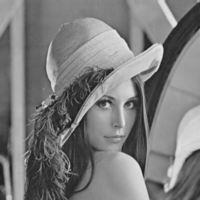

In [0]:
to_tensor = ToTensor()  # img -> tensor
to_pil = ToPILImage()  # tensor -> img
lena = Image.open('images/lena.png')
lena

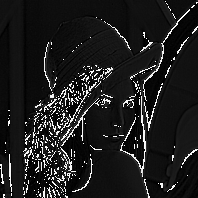

In [0]:
# 输入是一个batch， batch_size = 1
input = to_tensor(lena).unsqueeze(0)

# 锐化卷积核
kernel = torch.ones(3, 3) / -9
kernel[1][1] = 1

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(input)
to_pil(out.data.squeeze(0))

图像卷积操作其他变种：[https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)  
池化层可以看做是一种特殊的卷积层，用来下采样。但池化层没有可学习参数，其weight是固定的。

In [0]:
pool = nn.AvgPool2d(2, 2)
list(pool.parameters())

[]

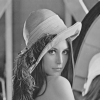

In [0]:
out = pool(input)
to_pil(out.data.squeeze(0))

除了卷积层和池化层外，神经网络常用到的其他层：
* Linear： 全连接层
* BatchNorm： 批规范化层，分为1D、2D和3D。还有风格迁移中常用到的InstanceNorm层
* Dropout层 ：用来防止过拟合，同样分为1D、2D和3D

In [0]:
# 输入batch_size=2，维度3
input = torch.randn(2, 3)
linear = nn.Linear(in_features=3, out_features=4)
h = linear(input)
h

tensor([[-0.0448,  0.0235,  0.1963,  0.7720],
        [ 0.2922,  0.3372,  1.7451,  0.4181]], grad_fn=<AddmmBackward>)

In [0]:
# 4 channel 初始化标准差为4，方差为0
bn = nn.BatchNorm1d(4)
bn.weight.data = torch.ones(4) * 4
bn.bias.data = torch.zeros(4)

bn_out = bn(h)
# 方差是标准差的平方，计算无偏方差分母会减1，使用unbiased=False,分母不减1
bn_out.mean(0), bn_out.var(0, unbiased=False)

(tensor([ 0.0000e+00,  2.3842e-07, -1.1921e-07,  7.1526e-07],
        grad_fn=<MeanBackward2>),
 tensor([15.9944, 15.9935, 15.9997, 15.9949], grad_fn=<VarBackward1>))

In [0]:
# 每个元素以0.5的概率舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o

tensor([[-0.0000, -0.0000, -7.9999,  0.0000],
        [ 0.0000,  7.9984,  7.9999, -0.0000]], grad_fn=<MulBackward0>)

#### 激活函数

$$ReLU = max(0, x)$$

In [0]:
relu = nn.ReLU(inplace=True)
input = torch.randn(2, 3)
print(input)
output = relu(input)
print(output)  # 小于0的被截断
# 等价于input.clamp(min=0)

tensor([[-0.6461,  0.6096, -0.6527],
        [ 0.7026, -0.4065, -0.5032]])
tensor([[0.0000, 0.6096, 0.0000],
        [0.7026, 0.0000, 0.0000]])


ReLU函数有个inplace参数，如果设为true，它会把输出直接覆盖到输入，这样可以减少内存/显存。但是只有少数的autograd操作支持inplace(tensor.sigmoid_)，除非明确知道，否则一般不使用inplace操作

In [0]:
# Sequential 的三种写法
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
  nn.Conv2d(3, 3, 3),
    nn.BatchNorm2d(3),
    nn.ReLU()
)

from collections import OrderedDict
net3 = nn.Sequential(
  OrderedDict([
      ('conv1', nn.Conv2d(3, 3, 3)),
      ('bn1', nn.BatchNorm2d(3)),
      ('relu1', nn.ReLU())
  ])
)

print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [0]:
# 可根据名称或序号取出
net1.conv, net2[1], net3.relu1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU())

In [0]:
input = torch.randn(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net3.bn1(net3.conv1(input)))
output

tensor([[[[0.0000, 0.0676],
          [0.0359, 0.0000]],

         [[0.0000, 0.0000],
          [0.3552, 0.0000]],

         [[0.0000, 0.8865],
          [0.1247, 0.2086]]]], grad_fn=<ReluBackward0>)

ModuleList 是Module的子类，当在Module中使用它的时候，能够自动识别为子module

In [0]:
modellist = nn.ModuleList([nn.Linear(3, 4), nn.ReLU(), nn.Linear(4, 2)])
input = torch.randn(1, 3)
for model in modellist:
  input = model(input)
 
# 下面会报错，因为modulelist没有实现forward
# output = modellist(input)

In [0]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [0]:
for name, param in model.named_parameters():
  print(name, param.size)

module_list.0.weight <built-in method size of Parameter object at 0x7fe38e316318>
module_list.0.bias <built-in method size of Parameter object at 0x7fe38e316090>


#### 循环神经网络RNN

In [0]:
torch.manual_seed(1000)  # 设置种子数
# 输入 batch_size = 3, 序列长度为2，序列中每个元素4维
input = torch.randn(2, 3, 4)
input

tensor([[[-0.5306, -1.1300, -0.6734, -0.7669],
         [-0.7029,  0.9896, -0.4482,  0.8927],
         [-0.6043,  1.0726,  1.0481,  1.0527]],

        [[-0.6424, -1.2234, -1.0794, -0.6037],
         [-0.7926, -0.1414, -1.0225, -0.0482],
         [ 0.6610, -0.8908,  1.4793, -0.3934]]])

In [0]:
# LSTM 输入向量4维，隐藏元 3， 1层
lstm = nn.LSTM(4, 3, 1)
# 初始状态： 1层， batch_size=3，3个隐藏单元
h0 = torch.randn(1, 3, 3)
c0 = torch.randn(1, 3, 3)
out, hn = lstm(input, (h0, c0))
out

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [0]:
torch.manual_seed(1000)
input = torch.randn(2, 3, 4)
# 一个LSTMCell对应的层数只能是一层
lstm = nn.LSTMCell(4, 3)
hx = torch.randn(3, 3)
cx = torch.randn(3, 3)
out = []
for i_ in input:
  hx, cx = lstm(i_, (hx, cx))
  out.append(hx)
torch.stack(out)

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [0]:
# 有4个词，每个词用5维的向量表示
embedding = nn.Embedding(4, 5)
# 可以用预训练好的词向量初始化embedding
embedding.weight.data = torch.arange(0, 20).view(4, 5)
embedding

Embedding(4, 5)

In [0]:
input = torch.arange(3, 0, -1).long()
output = embedding(input)
output

tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]], grad_fn=<EmbeddingBackward>)

#### 损失函数


In [0]:
# batch_size = 3
score = torch.randn(3, 2)
# 三个样本分别属于1， 0， 1类别，label必须是LongTensor
label = torch.tensor([1, 0, 1])

# loss与普通的layer无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

tensor(0.6955)

### 优化器
常用优化方法都在 `torch.optim`中。所有的优化方法都是继承基类 `torch.optim.Optimizer`，并实现了自己的优化步骤

In [0]:
# 首先定义一个LeNet
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.features = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    
  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 16 * 5 * 5)  # 扁平化用于全连接
    x = self.classifier(x)
    return x

In [0]:
from torch import optim

In [0]:
net = Net()

In [0]:
optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad()  # 梯度清零，等价于net.zero_grad()

input = torch.randn(1, 3, 32, 32)
output = net(input)
output.backward(output)

optimizer.step()  # 优化执行，更新参数

In [0]:
# 为不同子网络设置不同的学习率
# 如果对某个参数不指定学习率，就使用最外层的默认学习率
optimizer = optim.SGD([
    {'params': net.features.parameters()}, # 学习率默认 1e-5
    {'params': net.classifier.parameters(), 'lr': 1e-2}
], lr=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [0]:
# 只为2个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0], net.classifier[3]])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = filter(lambda p: id(p) not in special_layers_params, net.parameters())

optimizer = optim.SGD([
    {'params': base_params},
    {'params': special_layers.parameters(), 'lr': 0.01}
], lr=0.001)
optimizer


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

对于调整学习率，主要有两种做法：
* 修改optimizer.param_groups中对应的学习率
* 新建优化器(推荐)，但是对于使用动量的优化器(如Adam
)，会丢失动量等状态信息，可能呢会造成损失函数的收敛出现震荡的情况

In [0]:
# 方法1：调整学习率，重建一个optimizer
old_lr = 0.1
optimizer1 =optim.SGD([
                {'params': net.features.parameters()},
                {'params': net.classifier.parameters(), 'lr': old_lr*0.1}
            ], lr=1e-5)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [0]:
# 方法2： 调整学习率，手动decay，保存动量
for param_group in optimizer.param_groups:
  param_group['lr'] *= 0.1
  
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### nn.functional
nn中的大多数layer，在functional中都有一个对应的函数。nn.functional中的函数和nn.Module的主要区别在于，用nn.Module实现的layer是一个特殊的类，都是由`class layer(nn.Module)`定义，会自动提取可学习的参数。而nn.functional中的函数更像是纯函数。有`def function(input)`定义。   
如果模型有可学习的参数，最好用nn.Module，否则2者都可以以使用。激活函数和池化层由于没有可学习的参数，可以使用funcation函数代替

In [0]:
input = torch.randn(2, 3)
model = nn.Linear(in_features=3, out_features=4)
output1 = model(input)
output2 = nn.functional.linear(input, model.weight, model.bias)
output1 == output2

tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]], dtype=torch.uint8)

In [0]:
nn.functional.linear??

In [0]:
b1 = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b1 == b2

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.uint8)

In [0]:
from torch.nn import functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = F.pool(F.relu(self.conv1(x)), 2)
    x = F.pool(F.relu(self.conv2(x)), 2)
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [0]:
class MyLinear(nn.Module):
  def __init__(self):
    super(MyLinear, self).__init__()
    
    self.weight = nn.Parameter(torch.randn(3, 4))
    self.bias = nn.Parameter(torch.zeros(3))
    
  def forward(self, x):
    return F.linear(input, self.weight, self.bias)

### 初始化策略
参数初始化

In [0]:
# 利用nn.init初始化
from torch.nn import init

In [0]:
linear = nn.Linear(3, 4)

torch.manual_seed(1)
# 等价于linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]], requires_grad=True)

In [0]:
# 直接初始化
import math

In [0]:
torch.manual_seed(1)

# xzvier初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.)
linear.weight.data.normal_(0, std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [0]:
# 对模型的所有参数进行初始化
for name, params in net.named_parameters():
  if name.find('linear') != -1:
    # init linear
    params[0] # weight
    params[1] # bias
  elif name.find('conv') != -1:
    pass
  elif name.find('norm') != -1:
    pass

### nn.Module深入分析

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    # 等价于self.register_parameter('param1', nn.Parameter(torch.randn(3, 3)))
    self.param1 = nn.Parameter(torch.rand(3, 3))
    self.bias = nn.Parameter(torch.randn(3))
    self.submodel1 = nn.Linear(3, 4)
    
  def forward(self, x):
    x = self.param1.mm(input)
    x = self.submodel1(x)
    return

In [0]:
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [0]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [0]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[0.5239, 0.7981, 0.7718],
                      [0.0112, 0.8100, 0.6397],
                      [0.9743, 0.8300, 0.0444]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([ 0.3935,  1.1322, -0.5404], requires_grad=True))])

In [0]:
# 等价于net._parameters['bias']
net.bias

Parameter containing:
tensor([ 0.3935,  1.1322, -0.5404], requires_grad=True)

In [0]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
bias torch.Size([3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [0]:
for  name, submodel in net.named_modules():
  print(name, submodel)

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [0]:
bn = nn.BatchNorm1d(2)
input = torch.randn(3, 2)
output = bn(input)
bn._buffers

OrderedDict([('running_mean', tensor([0.0403, 0.0039])),
             ('running_var', tensor([1.0305, 1.1057])),
             ('num_batches_tracked', tensor(1))])

In [0]:
# 运行该段代码colab会异常崩溃
input = torch.arange(0, 12).view(3, 4)
model = nn.Dropout()
# 在训练阶段，会有一半左右的数被随机置为0
model(input)

### 搭建ResNet

In [0]:
import torch
from torch import nn
from torch.nn import functional as F

In [0]:
class ResidualBlock(nn.Module):
  """实现submodule Residual Block"""
  def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
    super(ResidualBlock, self).__init__()
    
    self.left = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias = False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channel)
    )
    
    self.right = shortcut
  
  def forward(self, x):
    out = self.left(x)
    residual = x if self.right is None else self.right(x)
    out += residual
    return F.relu(out)
    
    

In [0]:
class ResNet(nn.Module):
  """
  实现主Module：ResNet34
  包含多个layer，每个layer又包含多个residual_block
  用子module来实现 residual block,用_make_layer函数来实现layer
  """
  def __init__(self, num_classes=100):
    super(ResNet, self).__init__()
    
    # 前几层图像转换
    self.pre = nn.Sequential(
        nn.Conv2d(3, 64, 7, 2, 3, bias=True),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    
    # 重复的layer，分别有3， 4， 6， 3个residual block
    self.layer1 = self._make_layer(64, 64, 3)
    self.layer2 = self._make_layer(64, 128, 4, stride=2)
    self.layer3 = self._make_layer(128, 256, 6, stride=2)
    self.layer4 = self._make_layer(256, 512, 3, stride=2)
    
    # 分类用的全连接
    self.fc = nn.Linear(512, num_classes)
    
  def _make_layer(self, in_channel, out_channel, block_num, stride=1):
    """构建layer，包含多个residual block"""
    shortcut = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 1, stride, bias=False),
        nn.BatchNorm2d(out_channel)
    )
    
    layers = []
    layers.append(ResidualBlock(in_channel, out_channel, stride, shortcut))
    
    for i in range(1, block_num):
      layers.append(ResidualBlock(out_channel, out_channel))
    
    return nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.pre(x)
    
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    
    x = F.avg_pool2d(x, 7)
    x = x.view(x.size(0), -1)
    return self.fc(x)

In [0]:
model = ResNet()
input = torch.randn(1, 3, 224, 224)
output = model(input)

In [24]:
output

tensor([[-0.2890,  0.5216,  0.7710,  0.5015,  0.1955,  0.6991, -0.0245, -0.1566,
         -0.5020,  0.1732, -0.1994, -0.3578,  0.0296, -0.0944, -0.0721,  0.3174,
         -0.4324,  0.0604, -0.4839,  0.0880, -0.0830, -0.3962,  0.2165, -0.3277,
          0.1987,  0.0030, -0.1002, -0.0464,  0.4073, -0.2950, -0.1015,  0.4034,
         -0.2374, -0.5320,  0.3112, -0.4248,  0.3040,  0.3917,  0.0408, -0.0903,
          0.3095,  0.0497, -0.4211, -0.2971, -0.2343, -0.1176, -0.1344,  0.3847,
          0.6369,  0.1296, -0.1054, -0.2002, -0.3766,  0.1002,  0.4726,  0.0129,
          0.5805, -0.1693, -0.6229, -0.3489, -0.1278, -0.0913, -0.5395,  0.2532,
          0.2780, -0.4201, -0.1757, -0.2961, -0.3401,  0.3565,  0.1716,  0.1620,
          0.4715, -0.3719, -0.1365, -0.0503, -0.3875, -0.3982,  0.0114,  0.6092,
         -0.0024, -0.5364, -0.0747,  0.1837,  0.1240, -0.0471,  0.1605,  1.0079,
          0.0634, -0.3735,  0.2831, -0.0393,  0.1427, -0.1023,  0.2068,  0.0800,
          0.0543, -0.3827,  